In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
path="H:/My Drive/jkas/Mitacs/LabRisk/Datasets/TWEETS/TWEETS"
print(os.listdir(path))

['PRUEBA', 'NO-TWEETS', 'TWEETS', 'train']


In [41]:
FAST_RUN = False
IMAGE_WIDTH=512
IMAGE_HEIGHT=512
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [42]:
filenames = os.listdir(path+"/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'yes':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [43]:
df.head()

,filename,category
0,yes.0.jpg,1
1,yes.1.jpg,1
2,yes.2.jpg,1
3,yes.3.jpg,1
4,yes.4.jpg,1


<AxesSubplot:>

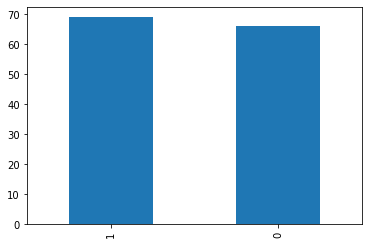

In [44]:
df['category'].value_counts().plot.bar()

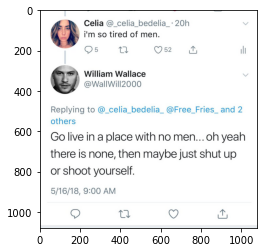

In [45]:
sample = random.choice(filenames)
image = load_img(path+"/train/"+sample)
plt.imshow(image)

In [46]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 510, 510, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 510, 510, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 253, 253, 64)      256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 126, 126, 64)     

In [47]:
earlystop = EarlyStopping(patience=10)

In [48]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [49]:
callbacks = [earlystop, learning_rate_reduction]

In [50]:
df["category"] = df["category"].replace({0: 'no', 1: 'yes'}) 

In [51]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

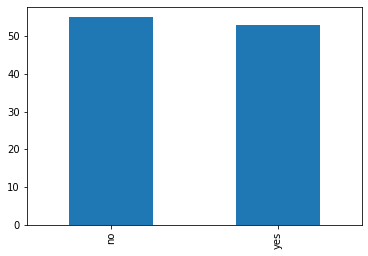

In [52]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

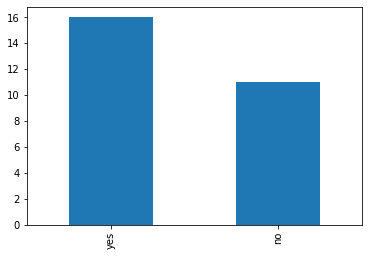

In [53]:
validate_df['category'].value_counts().plot.bar()

In [54]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [55]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    path+"/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 108 validated image filenames belonging to 2 classes.


In [56]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    path+"/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 27 validated image filenames belonging to 2 classes.


In [57]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    path+"/train/",  
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


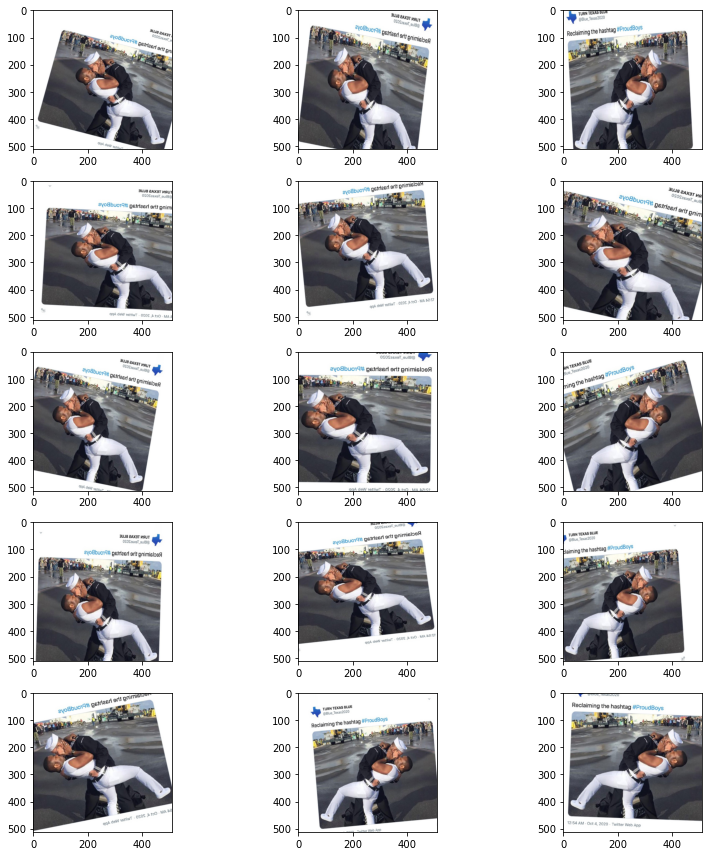

In [58]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [59]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\jkash\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
7/7 [==============================] - 54s 8s/step - loss: 1.4707 - accuracy: 0.6452 - val_loss: 4.4681 - val_accuracy: 0.4667
Epoch 2/50
7/7 [==============================] - 53s 7s/step - loss: 1.3067 - accuracy: 0.6022 - val_loss: 4.3671 - val_accuracy: 0.6000
Epoch 3/50
7/7 [==============================] - 53s 7s/step - loss: 0.8892 - accuracy: 0.6774 - val_loss: 5.0663 - val_accuracy: 0.8000
Epoch 4/50
7/7 [==============================] - 55s 8s/step - loss: 0.4974 - accuracy: 0.7849 - val_loss: 12.5888 - val_accuracy: 0.4000
Epoch 5/50
7/7 [==============================] - 53s 8s/step - loss: 0.7678 - accuracy: 0.6989 - val_loss: 49.9687 - val_accuracy: 0.3333
Epoch 6/50
7/7 [==============================] - 53s 8s/step - loss: 1.2515 - accuracy: 0.6989 - val_loss: 63.5720 - val_accuracy: 0.2667
Epoch 7/50
7/7 [==============================] - 54s 7s/step - loss: 0.7845 - accuracy: 0.7204 - val_loss: 66.5495 - val_accuracy: 0.4000
Epoch 8/50
7/7 [==============

In [60]:
model.save_weights("modelTweets.h5")

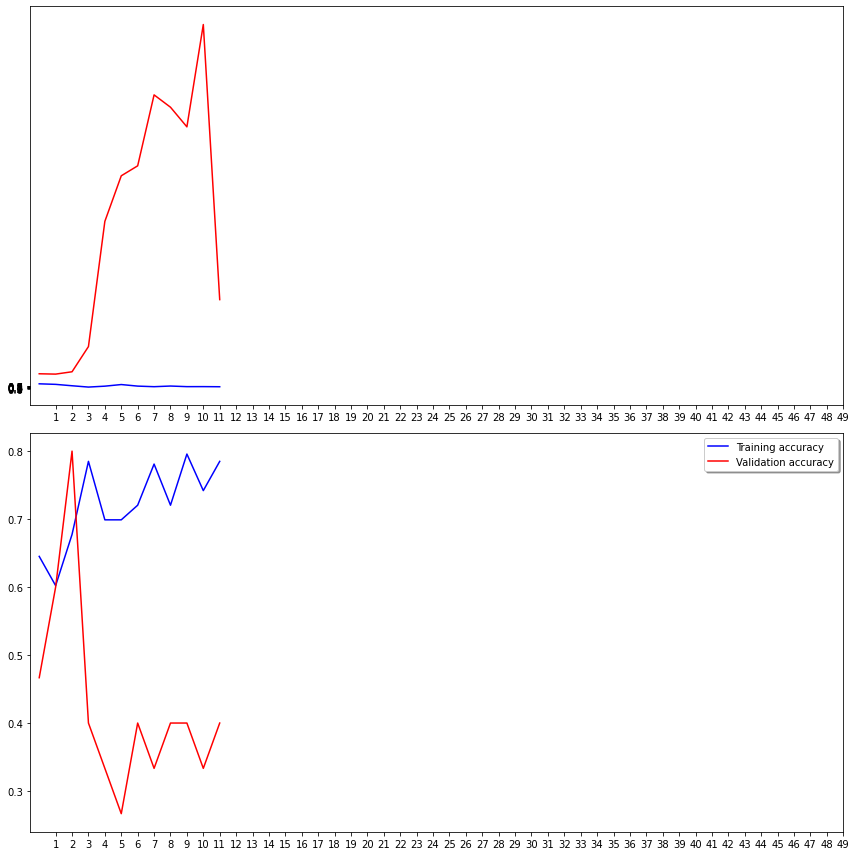

In [61]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [62]:
test_filenames = os.listdir(path+"/PRUEBA")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [63]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    path+"/PRUEBA", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 30 validated image filenames.


In [64]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\jkash\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2030: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [65]:
test_df['category'] = np.argmax(predict, axis=-1)

In [66]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [67]:
test_df['category'] = test_df['category'].replace({ 'yes': 1, 'no': 0 })

<AxesSubplot:>

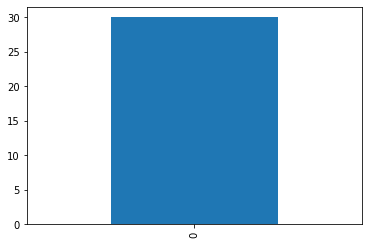

In [68]:
test_df['category'].value_counts().plot.bar()

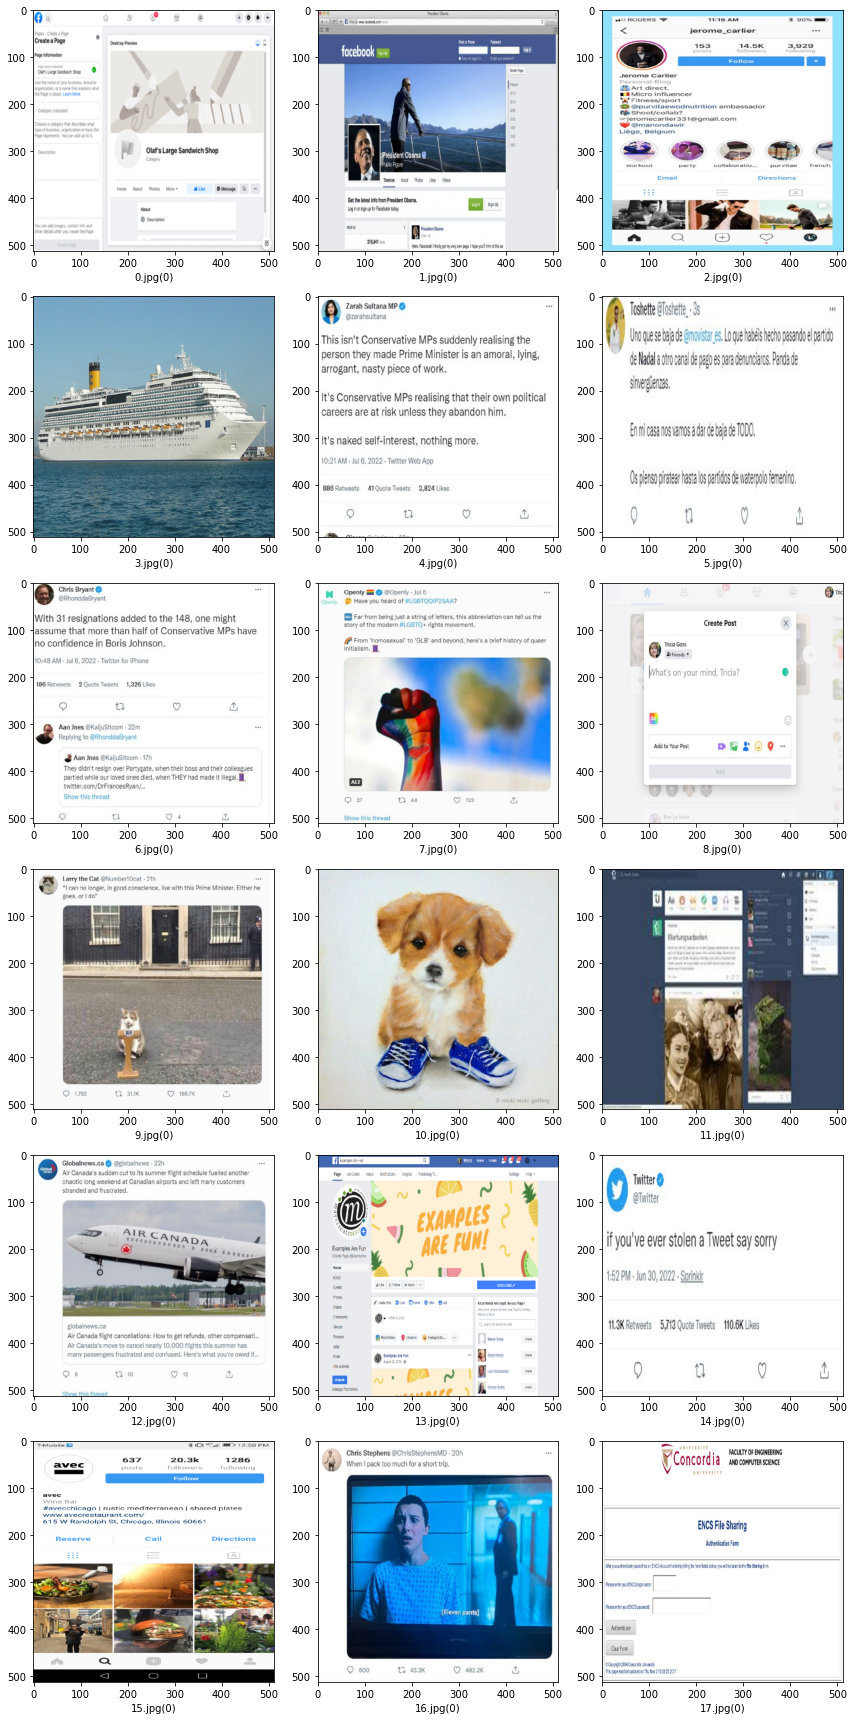

In [69]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(path+"/PRUEBA/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [40]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('proof1.csv', index=False)